In [1]:
import gc
import glob
import os
import sys
import cv2
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from random import randrange
from time import time
from tqdm import tqdm, tnrange
from tqdm.notebook import tqdm_notebook

import warnings

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

from keras.optimizer_v2.gradient_descent import SGD
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers import Dense, MaxPooling2D, Flatten, Conv2D, Lambda, Dropout, LeakyReLU, BatchNormalization, Activation, AveragePooling2D, GlobalAveragePooling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator

from mlxtend.evaluate import accuracy

from tensorflow.keras.optimizers import Adam,RMSprop,SGD, Nadam
#from tensorflow.keras.utils import to_categorical
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # ignore tensorflow warnings
warnings.filterwarnings("ignore")

In [3]:
path_data = "data/data_palm_vein/NIR"

In [4]:
def load_img(path, xdim=128, ydim=128, nb_of_users = 500):
    label_names = []
    X = []
    y = []
    nb_of_users = nb_of_users - 1
    count = 0
    identity = -1
    directories = os.listdir(path)
    directories.sort()
    for dirname in tqdm_notebook(directories, desc="Loading images..."):
        if dirname == ".DS_Store": continue
        label_names.append(dirname)
        data_path = os.path.join(path + "/" + dirname, '*g')
        files = glob.glob(data_path)
        if identity >= nb_of_users: break
        identity += 1
        files.sort()
        for f1 in files:
            img = cv2.imread(f1, cv2.IMREAD_GRAYSCALE)
            #img = cv2.imread(f1)
            #img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
            img = cv2.resize(img,(int(xdim*1), int(ydim*1)))
            #X.append([np.array(img), np.array(img), np.array(img)])
            #X.append(np.array(img))
            #X.append(np.array(img))
            X.append(np.array(img))
            #stacked_img = np.stack((img,)*3, axis=-1)
            #X.append(stacked_img)
            y.append(identity)
            count += 1
    X = np.array(X)
    y = np.array(y)
    print("\n ================= Summary of extraction ================= \n")
    print(count, ' images lues')
    print("\nX.shape = ", X.shape)
    print("y.shape = ", y.shape)
    gc.collect()
    return X, y, label_names

In [5]:
X, y, label_names = load_img(path_data, nb_of_users=500)

Loading images...:   0%|          | 0/501 [00:00<?, ?it/s]


 ================= Summary of extraction ================= 

6000  images lues

X.shape =  (6000, 128, 128)
y.shape =  (6000,)


In [6]:
X = X / 255.
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
y = to_categorical(y)

print("\nPREPROCESSING DATA")
print("--------------------------------------------------------------------------------\n")
print("\nX shape : {:19}   |   y shape : {}".format(str(X.shape), y.shape))
print("\n\n--------------------------------------------------------------------------------")
print("Il y a {} utilisateur(s) et plus de {} images de veines palmaires dans le dataset prélevé.".format(y.shape[1], y.shape[0]))


PREPROCESSING DATA
--------------------------------------------------------------------------------


X shape : (6000, 128, 128, 1)   |   y shape : (6000, 500)


--------------------------------------------------------------------------------
Il y a 500 utilisateur(s) et plus de 6000 images de veines palmaires dans le dataset prélevé.



=============================== Show datasets =============================== 




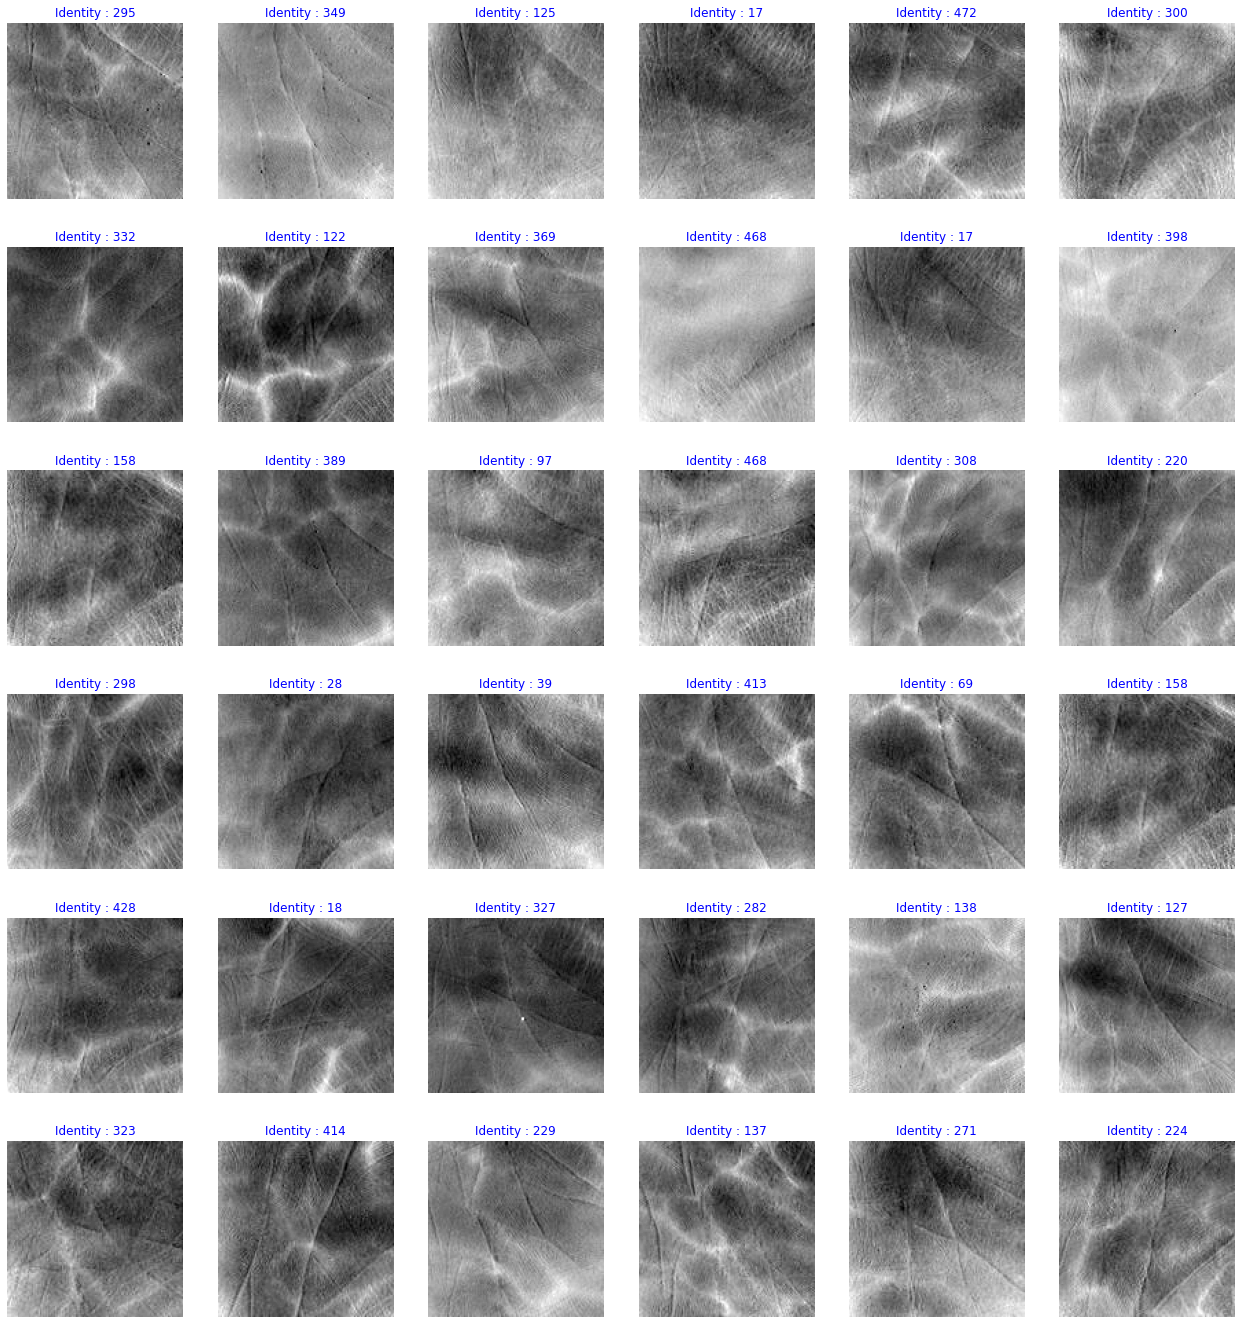

In [7]:
plt.figure(figsize=(22, 24))
print("\n=============================== Show datasets =============================== \n\n")

for i in range(36):
    ax = plt.subplot(6, 6, i + 1)
    r = randrange(y.shape[0])
    plt.imshow(X[r], cmap=plt.cm.binary)
    title_obj = plt.title("Identity : {}".format(np.argmax(y[r])))
    plt.setp(title_obj, color='blue')
    plt.axis("off")

In [8]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print("\nSplitting data ...\n")
print("\n=============================== Splitting data =============================== \n\n")
print("X_train shape   : {:19}    |    y_train shape : {}\n".format(str(X_train.shape), y_train.shape))
print("------------------------------------------------------------------------------")
print("X_val shape     : {:19}    |    y_val shape   : {}\n".format(str(X_val.shape), y_val.shape))
print("------------------------------------------------------------------------------")
print("X_test shape    : {:19}    |    y_test shape  : {}\n".format(str(X_test.shape), y_test.shape))


Splitting data ...


=============================== Splitting data =============================== 


X_train shape   : (4200, 128, 128, 1)    |    y_train shape : (4200, 500)

------------------------------------------------------------------------------
X_val shape     : (900, 128, 128, 1)     |    y_val shape   : (900, 500)

------------------------------------------------------------------------------
X_test shape    : (900, 128, 128, 1)     |    y_test shape  : (900, 500)



In [9]:
# function to create the model for Keras wrapper to scikit learn
# we will optimize the type of pooling layer (max or average) and the activation function of the 2nd and 3rd convolution layers 
def create_model(pool_type='max', conv_activation='relu', dropout_rate=0.15, classes=500, filters=32):
    # create model
    model = Sequential()
    # first layer: convolution
    model.add(Conv2D(filters*3, kernel_size=(7, 7), strides=(2,2), padding='valid', activation='relu', input_shape=(224, 224, 1))) 
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters*8, kernel_size=(5, 5), strides=(2,2), padding='same', activation='relu')) 
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters*16, kernel_size=(3, 3), strides=(1,1), padding='same', activation='relu')) 
    model.add(Conv2D(filters*32, kernel_size=(3, 3), strides=(1,1), padding='same', activation='relu')) 
    model.add(Conv2D(filters*16, kernel_size=(3, 3), strides=(1,1), padding='same', activation='relu')) 
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(rate=dropout_rate))     
    
    model.add(Flatten())         
    model.add(Dense(filters*288, activation='relu')) # 64
    if dropout_rate != 0:
        model.add(Dropout(rate=dropout_rate)) 
    model.add(Dense(filters*128, activation='relu')) # 64
    model.add(Dropout(rate=dropout_rate)) 
    model.add(Dense(filters*125, activation='relu')) # 64
    model.add(Dropout(rate=dropout_rate)) 
    model.add(Dense(classes, activation='softmax'))
    
    # Compile model
    model.compile( 
        optimizer='nadam',
        loss='categorical_crossentropy',
        metrics=['accuracy'],
        )
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.7, 
                                            min_lr=0.00000000001)    
    return model, learning_rate_reduction

cnn, lr_reduction = create_model(classes=y.shape[1])

cnn.compile(
  optimizer='nadam',
  loss='categorical_crossentropy',  
  metrics=['accuracy'],
)

n_epochs = 40 # 30 
n_epochs_cv = 10 # 10  # reduce number of epochs for cross validation for performance reason

n_cv = 3
validation_ratio = 0.10
#define callbacks
#early_stop = EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience=5, restore_best_weights=True)

cnn.summary()

Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 109, 109, 96)      4800      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 54, 54, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 512)       1180160   
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 1024)      4719616   
_________________________________________________________________
conv2d_4 (Conv2D)         

In [13]:
# Train the default CNN model
history = cnn.fit(
    X_train,
    y_train,
    epochs=n_epochs,  
    validation_data=(X_val, y_val), 
    batch_size=64,
    callbacks=lr_reduction
)

Epoch 1/40
57/57 [==============================] - 141s 2s/step - loss: 5.4523 - accuracy: 0.0594 - val_loss: 5.5823 - val_accuracy: 0.0325
Epoch 2/40
57/57 [==============================] - 154s 3s/step - loss: 5.4355 - accuracy: 0.0653 - val_loss: 5.5449 - val_accuracy: 0.0292
Epoch 3/40
57/57 [==============================] - 151s 3s/step - loss: 5.4328 - accuracy: 0.0706 - val_loss: 5.5850 - val_accuracy: 0.0417
Epoch 4/40
57/57 [==============================] - 141s 2s/step - loss: 5.4220 - accuracy: 0.0706 - val_loss: 5.5751 - val_accuracy: 0.0375
Epoch 5/40
57/57 [==============================] - 150s 3s/step - loss: 5.4309 - accuracy: 0.0711 - val_loss: 5.5343 - val_accuracy: 0.0617
Epoch 6/40
57/57 [==============================] - 146s 3s/step - loss: 5.3965 - accuracy: 0.0711 - val_loss: 5.5007 - val_accuracy: 0.0442
Epoch 7/40
57/57 [==============================] - 155s 3s/step - loss: 5.3805 - accuracy: 0.0761 - val_loss: 5.5472 - val_accuracy: 0.0575

Epoch 00007:

In [14]:
val = cnn.evaluate(X_test, y_test)

print("\n ================= Evaluation : 1 layer model ================= \n")
print("  Results : \n")
print("Loss  : %.2f" % (val[0]))
print("Score : %.2f%%" % (val[1] * 100))

38/38 [==============================] - 28s 718ms/step - loss: 5.2481 - accuracy: 0.1367

 ================= Evaluation : 1 layer model ================= 

  Results : 

Loss  : 5.25
Score : 13.67%


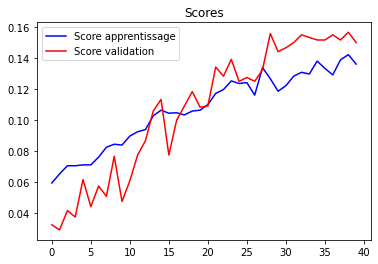

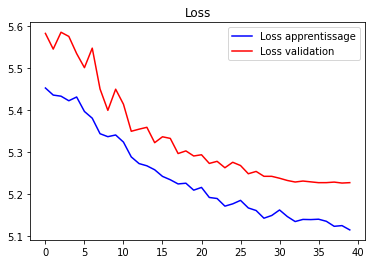

In [15]:
def plot_scores(train):
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Score apprentissage')
    plt.plot(epochs, val_accuracy, 'r', label='Score validation')
    plt.title('Scores')
    plt.legend()
    plt.show()
def plot_loss(train):
    loss = train.history['loss']
    val_loss = train.history['val_loss']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'b', label='Loss apprentissage')
    plt.plot(epochs, val_loss, 'r', label='Loss validation')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
plot_scores(history)
plot_loss(history)